<a href="https://colab.research.google.com/github/afrincon/visioncomputacional/blob/main/Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='blue'>**LABORATORIO 1. Comparación de clasificadores clásico y modernos**

<font color='red'>Integrantes: 
    
    Andrés Julian Jimenez - 2221988
    Andrés Felipe Rincon - 2227052


Adicione el código que sea necesario. No olvide comentarlo.

In [ ]:
!pip install kaggle

In [ ]:
# Montar drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
%mkdir -p /content/drive/MyDrive/CvwDL_2022_3/Entrega1

In [ ]:
%cd /content/drive/MyDrive/CvwDL_2022_3/Entrega1

In [ ]:
!kaggle datasets download die9origephit/nike-adidas-and-converse-imaged

In [ ]:
!unzip nike-adidas-and-converse-imaged.zip /content/drive/MyDrive/CvwDL_2022_3/Entrega1

Importando Librerias

In [ ]:
#coloque aqui todas las librerías que usará para desarrolar este laboratorio.
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array
import tensorflow as tf
from tqdm.auto import tqdm
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from google.colab.patches import cv2_imshow
import os
import random
from random import randint
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()

## <font color='blue'>**(30%) Parte 1. Mejorando su clasificador clásico.**

En aula hemos creado un clasificador de zapatos haciendo uso de diferentes tipos de features (SIFT, SURF, ORB) que son agrupadas a través del uso de un BoVW el cual genera un arreglo 1D, usada como entrada a una ANN que se encarga finalmente de la clasificación de 3 tipos de objetos.
Sin embargo el accuracy no supera el 55%. 

Utilice técnicas que usted conozca ( o investigue) que le permitan mejorar el accuracy hasta al menos un 80%. Usted puede hacer uso de cualquier técnica siempre y cuando, explique en que consiste y como logró parametrizarla para mejorar su resultado.

##BAG OF VISUAL WORDS

En este notebook observaremos la técnica de Data Augmentation para poder con el fin de mejorar las métricas, en este caso todas las imágenes se le apicaron un serie de transformaciones con el objetivo de que la el perceptron multicapa pueda tener mayor información después del procesamiento de obtener el método del codo de la forma mas óptima (el cual se mostrará también su procedimiento. Los parámetros transformados fueron los siguientes: 

- Trasladar la imagen 35px lateral derecho y 30px en el superior
- Trasladar la imagen 35px lateral izquierdo y 30px en la inferior
- Rotación de imagen 90 y 45 grados
- Flip horizonal (es decir que pone los zapatos al revés)

Se optó por esta última transformación porque los rasgos típicos que muestran las marcas entre tennis es más probable que que se puedan caputrar todos los patrones posibles que se observan en los descriptores

In [ ]:
etiquetas = os.listdir("train")
print(etiquetas)

['adidas', 'converse', 'nike']


In [ ]:
for dirname, _, filenames in os.walk("train"):
  for filename in filenames:
    print(os.path.join(dirname,filename))
    break

train/adidas/Rotate-17090.jpg
train/converse/Rotate-17090.jpg
train/nike/Rotate-17090.jpg


Se procede a crear las funciones para extraer cada imagen, aplicar el sift para obtener los detectores, la función para el K means, la distancia relativa

In [ ]:
#Función para cargar las imágenes desde el folder y ponerlas en un diccionario por categoría
def cargar_imagenes_desde_folder(folder):
  imagenes = {}
  for filename in os.listdir(folder):
    categoria = []
    ruta = folder + "/" + filename
    for cat in os.listdir(ruta):
      img = cv.imread(ruta + "/" + cat, cv.IMREAD_GRAYSCALE)
      if img is not None:
        categoria.append(img)
    imagenes[filename] = categoria
  return imagenes

#función para hallar descriptores
def sift_features(imagenes):
  sift_vectores = {}
  descriptor_list = []
  sift = cv.SIFT_create()
  for key, value in train.items():
    #imagenes es el diccionario de train y test
    features = []
    for img in value:
      kp,desc = sift.detectAndCompute(img, None)
      if desc is None:
        continue
      else:
        descriptor_list.extend(desc)
        features.append(desc)
    sift_vectores[key] = features
  return [descriptor_list, sift_vectores]

#función para sacar los descriptores con KMEANS
from sklearn.cluster import KMeans

def kmeans(k,descriptor_list):
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(descriptor_list)
  visual_words = kmeans.cluster_centers_
  return visual_words

from scipy.spatial import distance
def find_index(image, center):
  count = 0
  ind = 0
  for i in range(len(center)):
    if (i == 0):
      count = distance.euclidean(image, center[i])
    else:
      dist = distance.euclidean(image, center[i])
      if (dist < count):
        ind = i
        count = dist
  return ind

def img_clases(bovw, centers):
  dict_feat = {}
  for key, value in bovw.items():
    categoria = []
    for img in value:
      histo = np.zeros(len(centers))
      for each_feature in img:
        ind = find_index(each_feature,centers)
        histo[ind] += 1
      categoria.append(histo)
    dict_feat[key] = categoria
  return dict_feat

In [ ]:
train = cargar_imagenes_desde_folder("train")

In [ ]:
#Con esto se puede verificar cuantas imágenes quedaron por categoría
print(len(train["adidas"]),len(train["nike"]),len(train["converse"]))

1659 1659 1659


Podemos ver que por cada categoría aumentamos mucho la información de 237 a 1659 por cada categoria

In [ ]:
#Obteniendo la lista de descriptores y las caracteristicas
sifts = sift_features(train)
descriptor_list = sifts[0]
train_bovw_feat = sifts[1]

####Para determinar el K optimo que se debe tomar y donde la distorsión se aplana y tiende a tener un valor constate se hizo de la siguiente manera:


In [ ]:
wcss = list()

for i in range(1,150):
  clustering = KMeans(n_clusters=i, init='k-means++', random_state=42)
  clustering.fit(descriptor_list)
  wcss.append(clustering.inertia_)

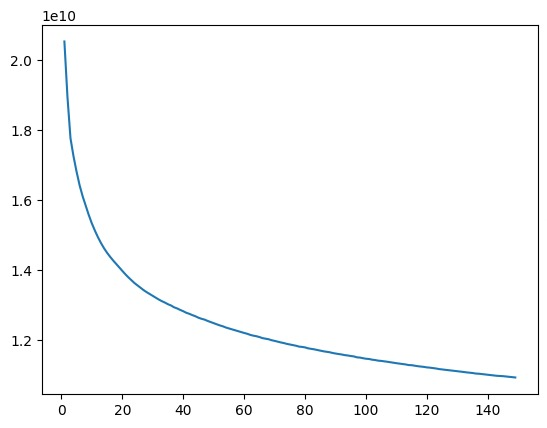

Opteniendo el K optimo y obteniendo las palabras visuales, en este caso se seleccionó 80 ya que aunque no hay una estructura clara de codo se tomo 80 ya que la desviación estandar de los valores mayores a 80 no varian tanto

In [ ]:
visual_words = kmeans(80,descriptor_list)

Cuadrando las carácteristicas de las palabras visuales con los centros

In [ ]:
bovw_train = img_clases(train_bovw_feat,visual_words)

In [ ]:
len(bovw_train["nike"])

1659

Preparar los datos para poder ingresar a la capa ya que tienen que ingresar como un array

In [ ]:
def preparar_datos(diccio):
  y = []
  x = []
  for key, values in diccio.items():
    for img in values:
      x.append(img)
      y.append(key)
  return np.array(x), np.array(y)

In [ ]:
x_train, y_train = preparar_datos(bovw_train)
print(x_train.shape)
print(y_train.shape)

(4977, 80)
(4977,)


###AHORA PARA DATOS DE VALIDACIÓN

In [ ]:
test = cargar_imagenes_desde_folder("test")

In [ ]:
test_bowv_feat = sift_features(test)

In [ ]:
test_bowv_feat = sift_features(test)[1]

In [ ]:
bovw_test = img_clases(test_bowv_feat, visual_words)

In [ ]:
x_test, y_test = preparar_datos(bovw_test)

In [ ]:
print(x_test.shape)
print(y_test.shape)

(4977, 80)
(4977,)


##Hacer Perceptron multicapa MLP

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

In [ ]:
std = StandardScaler().fit(x_train)
X_train = std.transform(x_train)

In [ ]:
X_test = std.transform(x_test)

Entonces se listan los mejores parametros obtenidos
- Activation: Relu
- Solver: Adam
- Alpha: 0.01
- hidden_layer_sizes: (140, 80)
- learining_rate : adapatative
- random_state: 10

In [ ]:
mlp = MLPClassifier((150,40),activation='relu', solver='adam',alpha=1,random_state=10)

In [ ]:
mlp.fit(X_train, y_train)
p = mlp.predict(x_test)
acc = accuracy_score(y_test, p)
M = confusion_matrix(y_test, p)

In [ ]:
print('El accuracy de la red es ', str(acc))

El accuracy de la red es  0.7054450472171991


# <font color='green'> Peparacion de datos para ingresarlos a los modelso LeNet, AlexNet y VGG16
visualizar datos train

In [ ]:
images = []
labels = []
for categoria in etiquetas:
  print('leyendo categoriaegorias', categoria)
  class_name = etiquetas.index(categoria)
  ruta = os.path.join('train', categoria)
  for img in tqdm(os.listdir(ruta)):
    img_array = cv.imread(os.path.join(ruta, img), cv.IMREAD_COLOR)
    new_array = cv.resize(img_array, (224,224))
    images.append(new_array)
    labels.append(class_name)

leyendo categoriaegorias adidas


  0%|          | 0/237 [00:00<?, ?it/s]

leyendo categoriaegorias converse


  0%|          | 0/237 [00:00<?, ?it/s]

leyendo categoriaegorias nike


  0%|          | 0/237 [00:00<?, ?it/s]

visualizar datos test

In [ ]:
imagest = []
labelst = []
for categoria in etiquetas:
  print('leyendo categoriaegorias', categoria)
  class_name = etiquetas.index(categoria)
  rutat = os.path.join('test', categoria)
  for img in tqdm(os.listdir(rutat)):
    img_arrayt = cv.imread(os.path.join(rutat, img), cv.IMREAD_COLOR)
    new_arrayt = cv.resize(img_arrayt, (224,224))
    imagest.append(new_arrayt)
    labelst.append(class_name)

leyendo categoriaegorias adidas


  0%|          | 0/38 [00:00<?, ?it/s]

leyendo categoriaegorias converse


  0%|          | 0/38 [00:00<?, ?it/s]

leyendo categoriaegorias nike


  0%|          | 0/38 [00:00<?, ?it/s]

In [ ]:
x_train = np.array(images)
y_train = np.array(labels)
x_test = np.array(imagest)
y_test = np.array(labelst)

In [ ]:
print("El conjunto de datos de entrenamiento tiene:{0} imagenes".format(x_train.shape))
print("El conjunto de datos de entrenamiento tiene:{0} etiquetas".format(y_train.shape))
print("El conjunto de datos de prueba tiene:{0} imagenes".format(x_test.shape))
print("El conjunto de datos de prueba tiene:{0} etiquetas".format(y_test.shape))

El conjunto de datos de entrenamiento tiene:(711, 224, 224, 3) imagenes
El conjunto de datos de entrenamiento tiene:(711,) etiquetas
El conjunto de datos de prueba tiene:(114, 224, 224, 3) imagenes
El conjunto de datos de prueba tiene:(114,) etiquetas


Realizando un plot de los datos

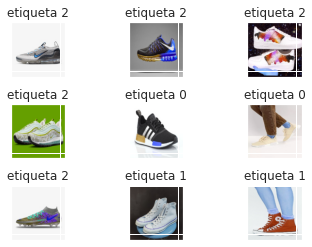

In [ ]:
for i in range(9):
  index = randint(0,len(x_train)-1)
  plt.subplot(3,3,i+1)
  plt.imshow(x_train[index], cmap='gray')
  plt.gca().set_xticklabels([index]) #control de ejes
  plt.gca().set_yticklabels([index]) #control de ejes
  plt.subplots_adjust(hspace=0.5)
  plt.gca().set_title("etiqueta " + str(y_train[index]))

Se procede a realizar la normalizacion de los datos para luego convertir las variables a predecir a one hot encoding usando la funcion **to_categorical**

In [ ]:
# Normalizacion de datos
x_train = (x_train - x_train.min()) / (x_train.max() - x_train.min())
x_test = (x_test - x_test.min()) / (x_test.max() - x_test.min())

In [ ]:
# cambiar a categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

### Aplicando tecnica de data augmentation para emplear en modelos LeNet, AlexNet y VGG16

In [ ]:
datagen = ImageDataGenerator(horizontal_flip=True,width_shift_range=0.1, height_shift_range=0.1, zoom_range=0.2,  rotation_range = 5)
it_train_dg = datagen.flow(x_train, y_train, batch_size=128, seed=7)
steps = int(x_train.shape[0] / 128) 

Realizando un plot de los datos con la tecnica de data augmentation aplicada

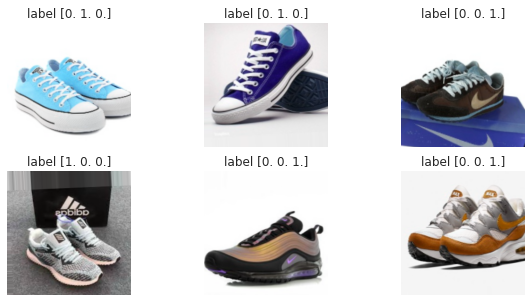

In [ ]:
plt.figure(figsize=(10,5))
for i in range(6):
  plt.subplot(2,3,i+1)
  for x, y in it_train_dg:
    plt.imshow(x[0])
    plt.title('label {}'.format(y[0]))
    plt.axis('off')
    break
plt.show()

# <font color='blue'>**(50%) Parte 2. Entrenando 3 arquitecturas CNN con Deep Learning**

Existen muchas arquitecturas basadas en deep Learning para crear clasificadores.
Usted deberá montar ("from scratch") y entrenar las siguientes 3 arquitecturas (para el dataset de zapatos):

In [ ]:
input_data=(224,224,3)

# LeNet

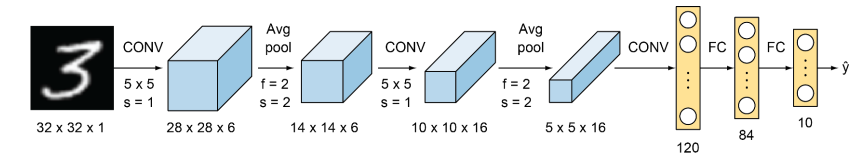

## Creación modelo LeNet mediante una funcion para luego usarlos con un callback

In [ ]:
def crear_modelo_lenet():
  modelo = Sequential([
      Conv2D(filters=6, kernel_size=(5,5), strides=(1,1), padding='valid', activation='relu', input_shape=input_data),
      MaxPooling2D(pool_size=(2,2), strides=(2,2)),
      Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'),
      MaxPooling2D(pool_size=(2,2), strides=(2,2)),

      Flatten(),
      Dense(120, activation='relu'),
      Dense(84, activation='relu'),
      Dense(3, activation='softmax')
  ])

  modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"] )

  return modelo

In [ ]:
# creacion y visualizacion del modelo
modelo_lenet = crear_modelo_lenet()
modelo_lenet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 220, 220, 6)       456       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 110, 110, 6)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 110, 110, 16)      2416      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 55, 55, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 48400)             0         
                                                                 
 dense_3 (Dense)             (None, 120)              

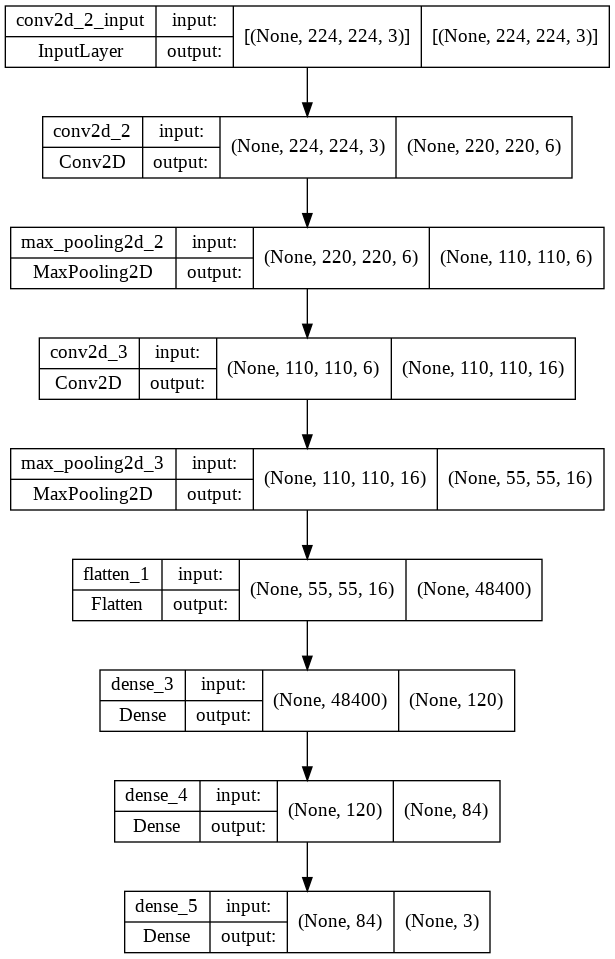

In [ ]:
# visualizacion del modelo en forma de bloques
plot_model(modelo_lenet, to_file='lenet.png', show_shapes=True, show_layer_names=True)

In [ ]:
# entrenando el modelo aplicando early stopping
cb_ea = EarlyStopping(monitor='val_loss', mode = 'min', patience=3)
history_lenet = modelo_lenet.fit(it_train_dg, epochs=20, steps_per_epoch=steps, validation_data=(x_test, y_test), verbose=1, callbacks=[cb_ea])

Epoch 1/20
5/5 [==============================] - 18s 1s/step - loss: 7.1030 - accuracy: 0.3482 - val_loss: 2.4630 - val_accuracy: 0.3333
Epoch 2/20
5/5 [==============================] - 6s 1s/step - loss: 2.1175 - accuracy: 0.3379 - val_loss: 1.1262 - val_accuracy: 0.3333
Epoch 3/20
5/5 [==============================] - 6s 1s/step - loss: 1.2489 - accuracy: 0.3465 - val_loss: 1.1725 - val_accuracy: 0.3333
Epoch 4/20
5/5 [==============================] - 6s 1s/step - loss: 1.1210 - accuracy: 0.3448 - val_loss: 1.0901 - val_accuracy: 0.3596
Epoch 5/20
5/5 [==============================] - 6s 1s/step - loss: 1.0910 - accuracy: 0.3688 - val_loss: 1.0743 - val_accuracy: 0.3333
Epoch 6/20
5/5 [==============================] - 6s 1s/step - loss: 1.0807 - accuracy: 0.3499 - val_loss: 1.0754 - val_accuracy: 0.3772
Epoch 7/20
5/5 [==============================] - 6s 1s/step - loss: 1.0713 - accuracy: 0.4172 - val_loss: 1.0656 - val_accuracy: 0.3772
Epoch 8/20
5/5 [========================

# AlexNet

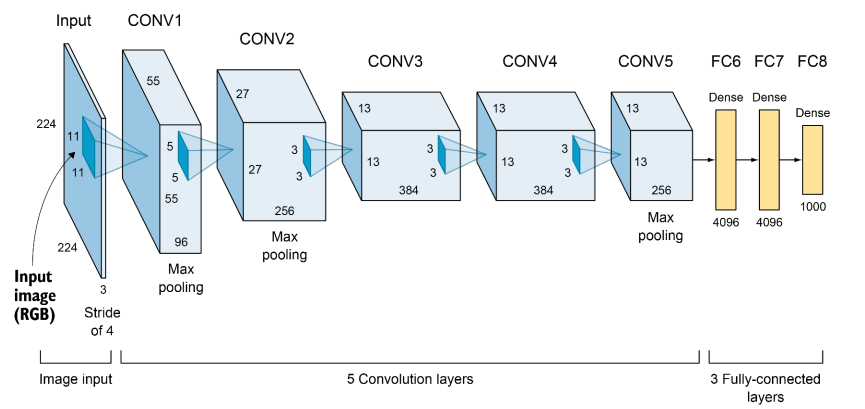

In [ ]:
def crear_modelo_alexnet():
  modelo = Sequential([
      Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=input_data),
      MaxPooling2D(pool_size=(3,3), strides=(2,2)),
      Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='valid', activation='relu'),
      MaxPooling2D(pool_size=(3,3), strides=(2,2)),

      Conv2D(filters=384, kernel_size=3, strides=(1,1), padding='same', activation='relu'),
      Conv2D(filters=384, kernel_size=3, strides=(1,1), padding='same', activation='relu'),
      Conv2D(filters=256, kernel_size=3, strides=(1,1), padding='same', activation='relu'),
      MaxPooling2D(pool_size=(3,3), strides=(2,2)),

      Flatten(),
      Dense(4096, activation='relu'),
      Dropout(0.5),
      Dense(4096, activation='relu'),
      Dropout(0.5),
      Dense(3, activation='softmax')
  ])

  modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"] )

  return modelo

In [ ]:
# creacion y visualizacion del modelo
modelo_alexnet = crear_modelo_alexnet()
modelo_alexnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 26, 26, 96)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 256)       614656    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 10, 256)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 10, 10, 384)       885120    
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 384)      

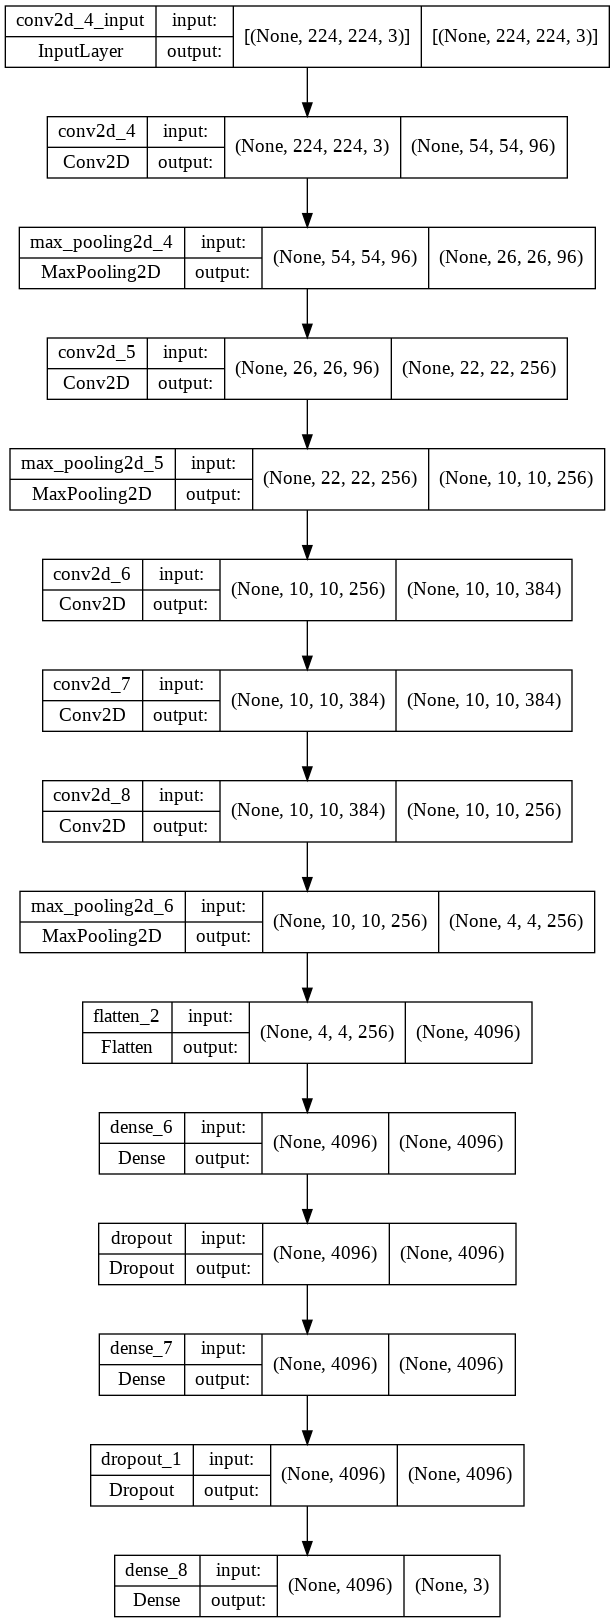

In [ ]:
# visualizacion del modelo en forma de bloques
plot_model(modelo_alexnet, to_file='alexnet.png', show_shapes=True, show_layer_names=True)

In [ ]:
# entrenando el modelo aplicando early stopping
cb_eat = EarlyStopping(monitor='val_loss', mode = 'min', patience=5)
history_alexnet = modelo_alexnet.fit(it_train_dg, epochs=20, steps_per_epoch=steps, validation_data=(x_test, y_test), verbose=1, callbacks=[cb_eat])

Epoch 1/20
5/5 [==============================] - 10s 2s/step - loss: 1.8161 - accuracy: 0.3482 - val_loss: 1.1025 - val_accuracy: 0.3333
Epoch 2/20
5/5 [==============================] - 6s 1s/step - loss: 1.1029 - accuracy: 0.3568 - val_loss: 1.0988 - val_accuracy: 0.3333
Epoch 3/20
5/5 [==============================] - 6s 1s/step - loss: 1.0993 - accuracy: 0.3396 - val_loss: 1.0985 - val_accuracy: 0.3421
Epoch 4/20
5/5 [==============================] - 6s 1s/step - loss: 1.0984 - accuracy: 0.3293 - val_loss: 1.0995 - val_accuracy: 0.3333
Epoch 5/20
5/5 [==============================] - 6s 1s/step - loss: 1.0997 - accuracy: 0.3156 - val_loss: 1.0985 - val_accuracy: 0.3333
Epoch 6/20
5/5 [==============================] - 6s 1s/step - loss: 1.0993 - accuracy: 0.3259 - val_loss: 1.0990 - val_accuracy: 0.3333
Epoch 7/20
5/5 [==============================] - 6s 1s/step - loss: 1.1000 - accuracy: 0.3156 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 8/20
5/5 [========================

# VGG16

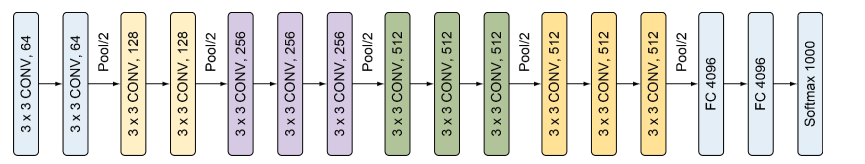

In [ ]:
def crear_modelo_vgg16():
  modelo = Sequential([
      Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=input_data),
      Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
      MaxPooling2D(pool_size=(2,2), strides=(2,2)),

      Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
      Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
      MaxPooling2D(pool_size=(2,2), strides=(2,2)),

      Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'),
      Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'),
      Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'),
      MaxPooling2D(pool_size=(2,2), strides=(2,2)),

      Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'),
      Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'),
      Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'),
      MaxPooling2D(pool_size=(2,2), strides=(2,2)),

      Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'),
      Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'),
      Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'),
      MaxPooling2D(pool_size=(2,2), strides=(2,2)),

      Flatten(),
      Dense(4096, activation='relu'),
      Dense(4096, activation='relu'),
      Dense(3, activation='softmax')
  ])

  modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"] )

  return modelo

In [ ]:
# creacion y visualizacion del modelo
modelo_vgg16 = crear_modelo_vgg16()
modelo_vgg16.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 conv2d_10 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 conv2d_12 (Conv2D)          (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                  

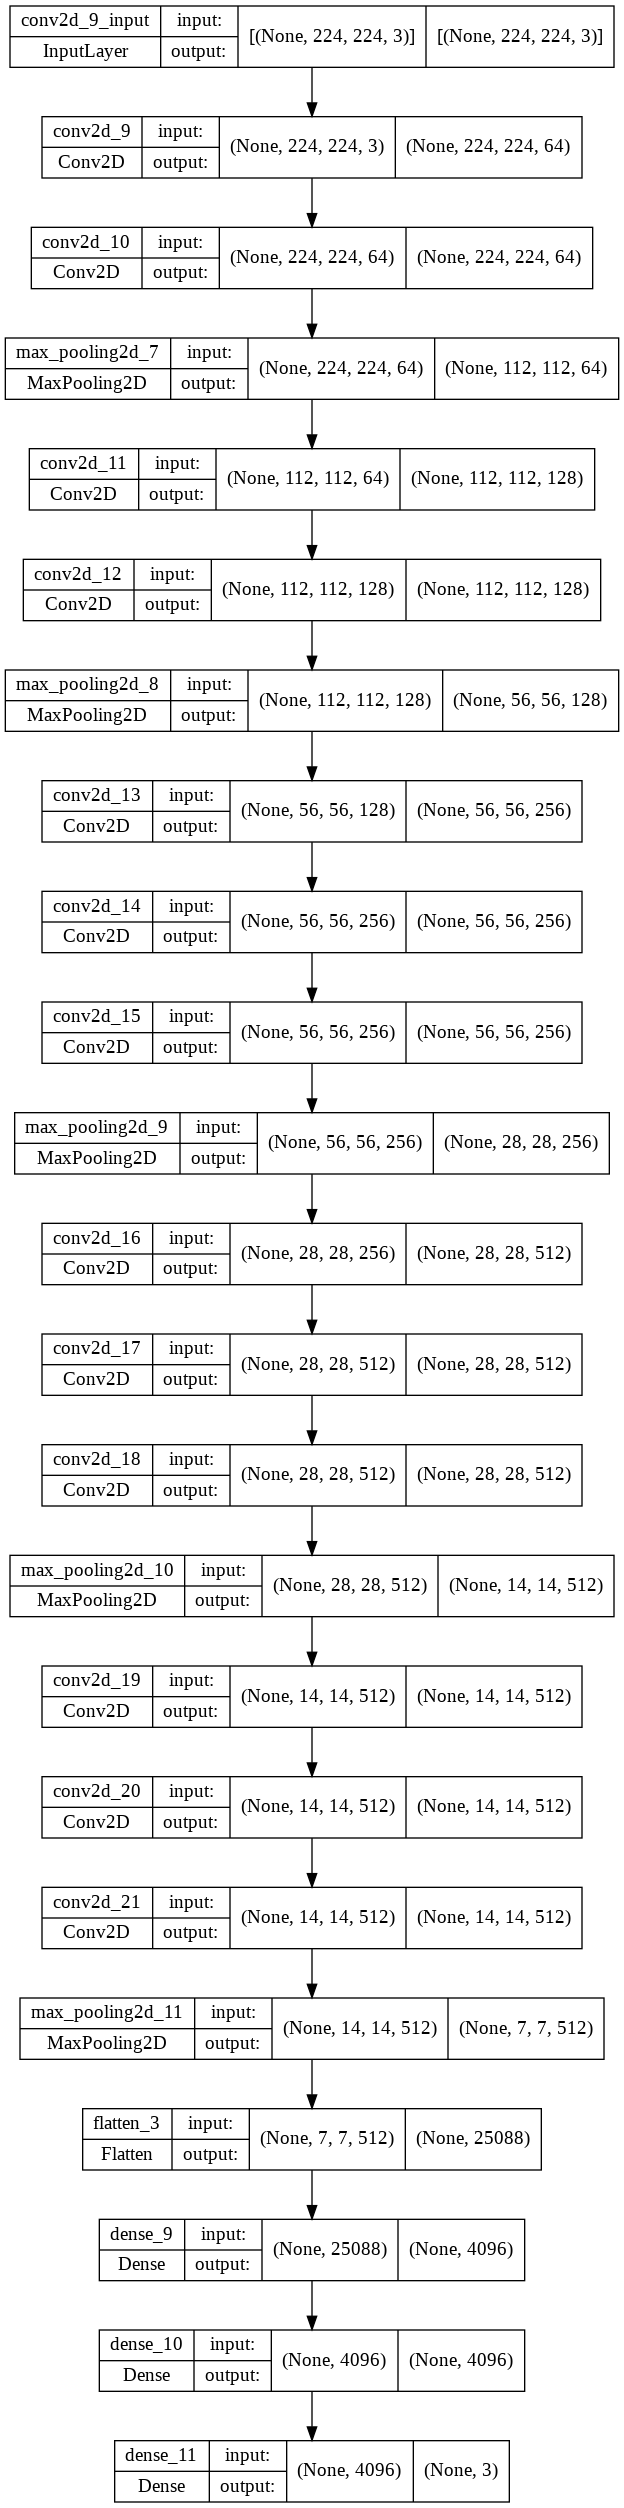

In [ ]:
# visualizacion del modelo en forma de bloques
plot_model(modelo_vgg16, to_file='vgg16.png', show_shapes=True, show_layer_names=True)

In [ ]:
# entrenando el modelo aplicando early stopping
cb_eav = EarlyStopping(monitor='val_loss', mode = 'min', patience=4)
history_vgg16 = modelo_vgg16.fit(it_train_dg, epochs=20, steps_per_epoch=steps, validation_data=(x_test, y_test), verbose=1, callbacks=[cb_eav])

Epoch 1/20
5/5 [==============================] - 10s 2s/step - loss: 1.0990 - accuracy: 0.3310 - val_loss: 1.0988 - val_accuracy: 0.3333
Epoch 2/20
5/5 [==============================] - 10s 2s/step - loss: 1.0996 - accuracy: 0.3208 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 3/20
5/5 [==============================] - 11s 2s/step - loss: 1.0986 - accuracy: 0.3379 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 4/20
5/5 [==============================] - 10s 2s/step - loss: 1.0985 - accuracy: 0.3482 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 5/20
5/5 [==============================] - 11s 2s/step - loss: 1.0989 - accuracy: 0.3276 - val_loss: 1.0987 - val_accuracy: 0.3333
Epoch 6/20
5/5 [==============================] - 11s 2s/step - loss: 1.0988 - accuracy: 0.3259 - val_loss: 1.0986 - val_accuracy: 0.3333
Epoch 7/20
5/5 [==============================] - 11s 2s/step - loss: 1.0987 - accuracy: 0.3413 - val_loss: 1.0986 - val_accuracy: 0.3333


## <font color='blue'>**(20%) Parte 3. Usando *Accuracy*, *Loss* y *Confusion* *Matrix* para comparar el *performance* de sus modelos**

Utilice las curvas de Loss , Accuracy y la matriz de confusión, para realizar  una tabla comparativa de los resultados obtenidos haciendo uso de los diferentes modelos previamente entrenados. Escriba al menos 3 conclusiones acerca de las técnicas aqui usadas que permitan conocer las "bondades" y los "defectos" de dichas técnicas.

###Realización de la manera tradicional BOVW

In [ ]:
bovw = confusion_matrix(y_test, p)

In [ ]:
labels = ['adidas','converse', 'nike']

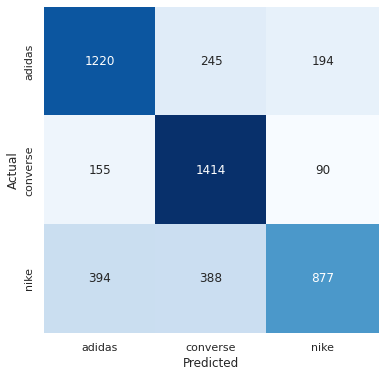

In [ ]:
plt.figure(figsize=(6,6))
sns.heatmap(bovw, cbar=False, xticklabels=labels, yticklabels=labels, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Finalmente se tiene la matriz, se analizaran las siguientes métricas de accuracy, precission, F1 score con respecto a cada clase

*Para la clase de adidas*

TP = 1220
TN = 1414 90 + 388 + 877
FP = 245 + 194
FN = 155 + 394

Pres = 0.735

Recall = 0.68

F1 = 0.711

Para la clase de Converse

TP = 1414
TN = 1220 + 394 + 877 + 194
FP = 155 + 90
FN = 388 + 245

Pres = 0.85

Recall = 0.69

F1 = 0.76

Para la clase de Nike

TP = 877
TN = 1220 + 155 + 1414 + 245
FP = 394 + 388
FN = 194 + 90

Pres = 0.52

Recall = 0.75

F1 = 0.62

LeNet Model

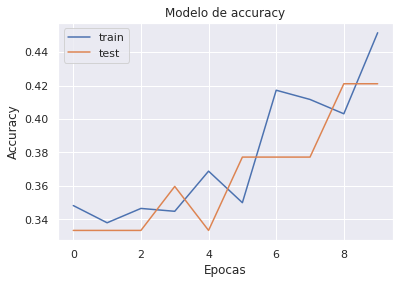

In [ ]:
# Graficando metrica de accuraxy
plt.plot(history_lenet.history['accuracy'])
plt.plot(history_lenet.history['val_accuracy'])
plt.title('Modelo de accuracy')
plt.xlabel('Epocas')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

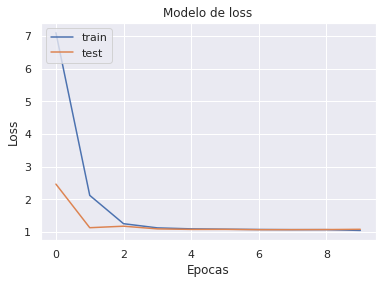

In [ ]:
# Graficando metrica del loss
plt.plot(history_lenet.history['loss'])
plt.plot(history_lenet.history['val_loss'])
plt.title('Modelo de loss')
plt.xlabel('Epocas')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Realizando predicciones de lenet

In [ ]:
# predicciones
predicciones_lenet = modelo_lenet.predict(x_test)

In [ ]:
y_test_non_category_lenet = [ np.argmax(t) for t in y_test ]
y_predict_non_category_lenet = [ np.argmax(t) for t in predicciones_lenet ]

In [ ]:
cn_lenet = confusion_matrix(y_test_non_category_lenet, y_predict_non_category_lenet)

In [ ]:
labels = ['adidas','converse', 'nike']

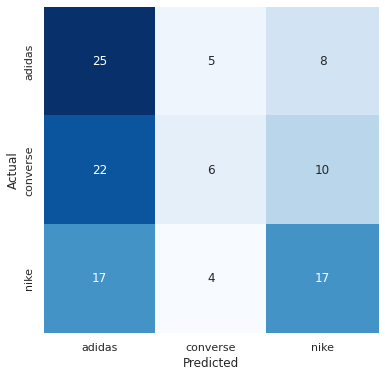

In [ ]:
plt.figure(figsize=(6,6))
sns.heatmap(cn_lenet, cbar=False, xticklabels=labels, yticklabels=labels, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# AlexNet Model

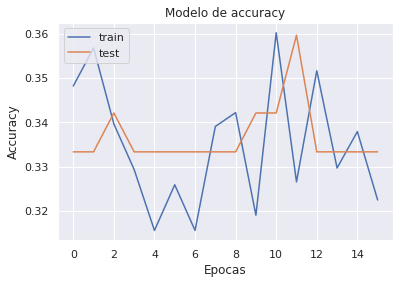

In [ ]:
# Graficando metrica de accuraxy
plt.plot(history_alexnet.history['accuracy'])
plt.plot(history_alexnet.history['val_accuracy'])
plt.title('Modelo de accuracy')
plt.xlabel('Epocas')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

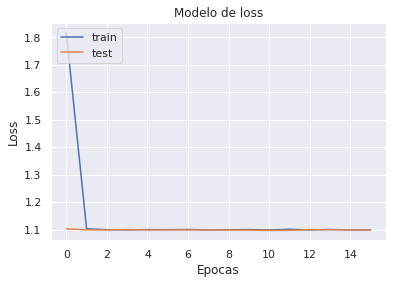

In [ ]:
# Graficando metrica del loss
plt.plot(history_alexnet.history['loss'])
plt.plot(history_alexnet.history['val_loss'])
plt.title('Modelo de loss')
plt.xlabel('Epocas')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# predicciones
predicciones_alexnet = modelo_alexnet.predict(x_test)

In [ ]:
y_test_non_category_alexnet = [ np.argmax(t) for t in y_test ]
y_predict_non_category_alexnet = [ np.argmax(t) for t in predicciones_alexnet ]

In [ ]:
cn_alexnet = confusion_matrix(y_test_non_category_alexnet, y_predict_non_category_alexnet)

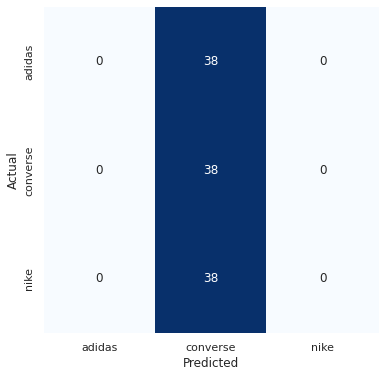

In [ ]:
plt.figure(figsize=(6,6))
sns.heatmap(cn_alexnet, cbar=False, xticklabels=labels, yticklabels=labels, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

VGG16 Model

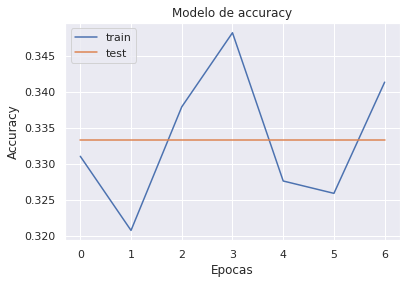

In [ ]:
# Graficando metrica de accuraxy
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Modelo de accuracy')
plt.xlabel('Epocas')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

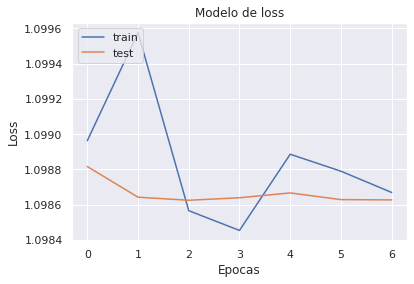

In [ ]:
# Graficando metrica del loss
plt.plot(history_vgg16.history['loss'])
plt.plot(history_vgg16.history['val_loss'])
plt.title('Modelo de loss')
plt.xlabel('Epocas')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# predicciones
predicciones_vgg16 = modelo_alexnet.predict(x_test)

In [ ]:
y_test_non_category_vgg16 = [ np.argmax(t) for t in y_test ]
y_predict_non_category_vgg16 = [ np.argmax(t) for t in predicciones_vgg16 ]

In [ ]:
cn_vgg16 = confusion_matrix(y_test_non_category_vgg16, y_predict_non_category_vgg16)

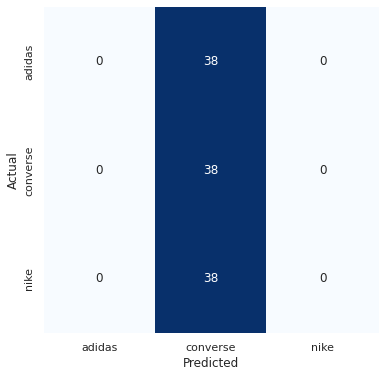

In [ ]:
plt.figure(figsize=(6,6))
sns.heatmap(cn_vgg16, cbar=False, xticklabels=labels, yticklabels=labels, fmt='d', annot=True, cmap=plt.cm.Blues)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# <font color='green'> Conclusiones:

<font color='gold'>
1. Se encuentra que apesar de ser redes de clasificación, con los modelos de AlexNet y VGG16 no se obtienen buenos resultados debido a que son redes complejas que necesitan mayor cantidad de datos para su entrenamiento.
<br>
<br>
<font color='gold'>
2. En nuestro caso tenemos 237 imágenes de entreamiento por cada clase. Nos fijaremos en el número de parámetros que se obtendrán por cada red. En el caso de Alexnet podemos ver que la operación en la primera capa convolucional son 96 filtros y en la segunda capa convolucional son 256, es decir que la proporción filtros:fotografía es un número que ronda la unidad. De esta forma los parámetros para cada foto que es ingresada a la red convolucional van a tener sus valores customizados. Es decir que la red va a gastar todos sus recursos para extraer características exclusivas de una foto en particular en vez de tratar de generalizar. De esta forma se puede justificar que el performance de la red sea una probabilidad básica sobre la marca que estamos intentando identificar (33.33%). En conclusión, tenemos una red muy compleja que toma cada muestra de Train como si fuese un caso especial por la falta de muestras (por esta parte podemos ver que el data auggmentation no tenga un buen performance persé).
<br>
<br>
<font color='gold'>
3. Como se explicaba arriba, de nuevo para la red VGG16 sucede el mismo caso, con 134 Millones de parámetros distribución de filtros entre que van desde 64, 128, 256 y 512. Y la cantidad de filtros respecto la cantidad de imágenes es una proporción menor, por lo tanto el performance va a tender directamente a 33.33%. De nuevo se hace alusión a la falta de muestras como afecta el performance de la Red.
<br>
<br>
<font color='gold'>
4. Para mejorar el rendimiento de este dataset se deben usar otro tipo de tecnicas diferentes a las aplicadas durante este laboratorio.